In [0]:
# Relevant Links
# Project Word doc 
# https://docs.google.com/document/d/1zAJgKoPRP5l8WqzqzP4HU1lE__b1vkzS02Ic0yzyfcI/edit

# Excel Sheet
# https://docs.google.com/spreadsheets/d/15rVWd1eWr9dfr_2U437EHc2DKTLunwqC7Ox-_phj4b4/edit#gid=0

In [0]:
# Dataset https://drive.google.com/drive/folders/18xAgpAeukvs2KfJChwzg7NW26M5rcU4A?usp=sharing
# Use upload option to uplad all the 4 files

In [0]:
from collections import Counter
from scipy.stats import gamma
from sklearn.preprocessing import MinMaxScaler
from google.colab import drive
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
plt.style.use('ggplot')

In [0]:
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
cd'/content/gdrive/My Drive/544Dataset/dataset'

/content/gdrive/My Drive/544Dataset/dataset


In [0]:
df = pd.read_csv('covid_data.csv')
zoom_df = pd.read_csv('zoom_data.csv')
zoom_both_years_df = pd.read_csv('zoom_both_years.csv')
df_master = pd.read_csv('covid_data_master.csv')

#Use this in Notebook
# df = pd.read_csv('dataset/covid_data.csv')
# zoom_df = pd.read_csv('dataset/zoom_data.csv')
# zoom_both_years_df = pd.read_csv('dataset/zoom_both_years.csv')
# df_master = pd.read_csv('dataset/covid_data_master.csv')

# Let's look what data we have!

In [0]:
df[:5]

,DATE,CASES,DEATHS,CASES_CF,DEATHS_CF
0,03/24/2020,132,1,730,5
1,03/25/2020,219,0,949,5
2,03/26/2020,200,4,1149,9
3,03/27/2020,340,3,1489,12
4,03/28/2020,393,3,1882,15


### These are all the features we have



1.   The datadrame shown above only has few features, this are all the features we have.
2.   Cases and fatalities by Age, Gender.
3.   We have info about both dailt and cummilative cases and fatalities


 
 





In [0]:
df_master.columns

Index(['DATE', 'CASES', 'DEATHS', 'CASES_CF', 'DEATHS_CF', 'Rate_of_cases',
       'Cases_CF_AGE_0_17', 'Cases_CF_AGE_18_59', 'Cases_CF_AGE_60plus',
       'Cases_AGE_0_17', 'Cases_AGE_18_59', 'Cases_AGE_60plus',
       'Cases_Female_CF', 'Cases_Male_CF', 'Cases_Female', 'Cases_Male',
       'Deaths_CF_AGE_0_17', 'Deaths_CF_AGE_18_59', 'Deaths_CF_AGE_60plus',
       'Deaths_AGE_0_17', 'Deaths_CF_AGE_18_59.1', 'Deaths_CF_AGE_60plus.1',
       'Deaths_female_CF', 'Deaths_male_CF', 'Deaths_female', 'Deaths_male'],
      dtype='object')

## Basic Info About Data

In [0]:
print ("DATASET EBGINS FROM: : " +str(df['DATE'].min()))
print ("DATASET ENDS AT: "+str(df['DATE'].max()))
print ("Total Days: "+str(len(df)))

DATASET EBGINS FROM: : 03/24/2020
DATASET ENDS AT: 05/08/2020
Total Days: 46


## Data Cleaning

*   1) Check for missing values and see how 
*   2) We will use the Tukey's rule to remove outliers

## Data Pre -Procesing

In [0]:
def exploreData(train):
    totalEntries = train.shape[0]
    
    dataInt = pd.DataFrame([])
    dataFloat = pd.DataFrame([])
    dataObj = pd.DataFrame([])
    for x in train.columns:
        if train[x].dtype.name == 'int64':
            dataInt = dataInt.append(exploreIntColums(x,train[x],totalEntries),ignore_index=True )
        else:
            print("other type")
    return dataInt

  
def exploreIntColums(columnName,columnData,totalEntries):
    missingEntries = totalEntries - columnData.count()
    tempDataObject = {}
    tempDataObject['Column Name'] = columnName
    tempDataObject['dType'] = 'int'
    tempDataObject['Missing Values(Count)'] = missingEntries
    tempDataObject['% of Missing Values'] = float(str(round(missingEntries*100/totalEntries,2)))
    tempDataObject['Mean'] = columnData.mean()
    tempDataObject['Standard Deviation'] = columnData.std()
    return tempDataObject

In [0]:
 a = exploreData(df[['CASES','DEATHS']])
 cols = ['Column Name','Mean','Mean','Standard Deviation','% of Missing Values','Missing Values(Count)','dType']
 a[cols]

,Column Name,Mean,Mean,Standard Deviation,% of Missing Values,Missing Values(Count),dType
0,CASES,631.891304,631.891304,295.094126,0.0,0.0,int
1,DEATHS,27.478261,27.478261,17.645571,0.0,0.0,int


As we can see from the above table as there are no missing values in both the columns of our intrest, i.e deaths and cases, there isn't anything we need to take care of missing values.

## Detect Outliers (Tukey's Rule)

In [0]:
#Reference: https://gist.github.com/joseph-allen/14d72af86689c99e1e225e5771ce1600
def detect_outliers(df, features):
    """
    Takes a dataframe df and list of features and returns a list of the indices
    which are outliers defined by the Tukey method.
    """
    outlier_indices = []

    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col], 75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        # outlier step
        outlier_step = 1.5 * IQR

        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        print("Outleiers in Column "+str(col) + " : " + str(len(outlier_indices)))
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list(k for k, v in outlier_indices.items())

    return multiple_outliers

In [0]:
features = ['CASES', 'DEATHS']
outliers_to_drop = detect_outliers(df, features)

Outleiers in Column CASES : 0
Outleiers in Column DEATHS : 0


### Since, we do not have any outlers in this dataset, no need to remove any values.

## Exploratory Data Analysis (EDA)

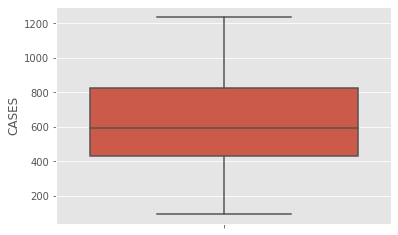

In [0]:
fig1 = sns.boxplot(y=df['CASES'])

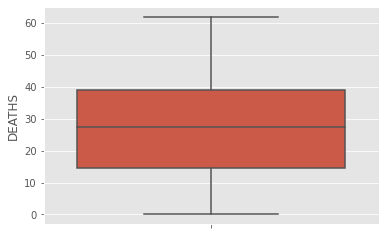

In [0]:
fig2 = sns.boxplot(y=df['DEATHS'])

### Both these boxplots, confirm our idea that our data in facet does not have any outliers

### There are no values in the extremium, so we did not find any outliers

## Plot 1

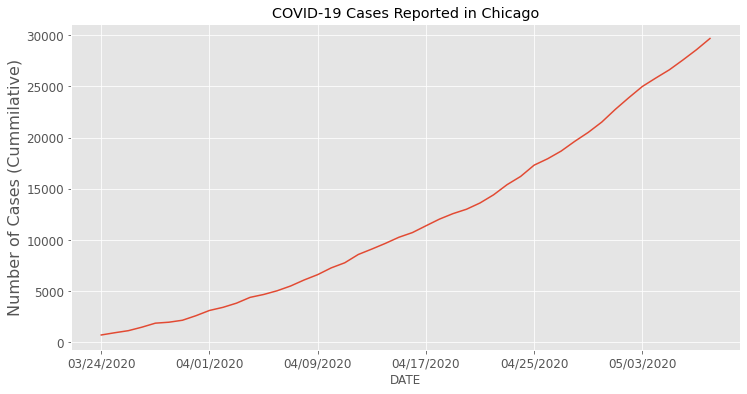

In [0]:
fig, ax = plt.subplots(figsize=(12,6))
sns.lineplot(x="DATE", y="CASES_CF", data=df)
plt.title('COVID-19 Cases Reported in Chicago')
plt.ylabel('Number of Cases (Cummilative)',fontsize = 16)
plt.xticks(np.arange(0, len(df), 8))
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.show()

## Plot 2

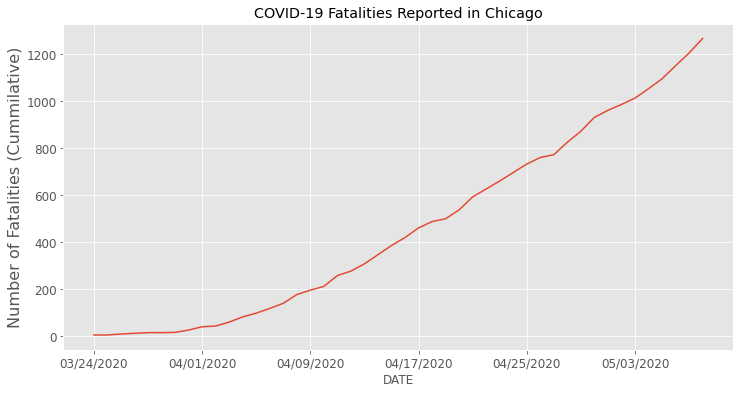

In [0]:
fig, ax = plt.subplots(figsize=(12,6))
sns.lineplot(x="DATE", y="DEATHS_CF", data=df)
plt.title('COVID-19 Fatalities Reported in Chicago')
plt.ylabel('Number of Fatalities (Cummilative)',fontsize = 16)
plt.xticks(np.arange(0, len(df), 8))
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.show()

### From the plots 1 and 2 , we can see that the growth of cases and fatalities for the data we have seem non linear.

## Plot 3

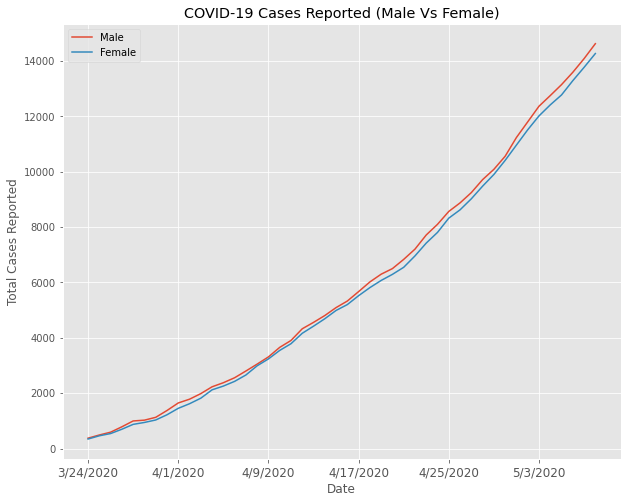

In [0]:
plt.figure(figsize=(10,8))
plt.plot(df_master['DATE'],df_master['Cases_Male_CF'], label='Male')
plt.plot(df_master['DATE'],df_master['Cases_Female_CF'], label='Female')
plt.legend(loc='best')
plt.title('COVID-19 Cases Reported (Male Vs Female)')
plt.ylabel('Total Cases Reported')
plt.xlabel('Date')
plt.xticks(np.arange(0, len(df_master), 8))
plt.xticks(fontsize = 12)
plt.show()

## The total cases reported for both the genders have grown at the same rate

## Plot 4

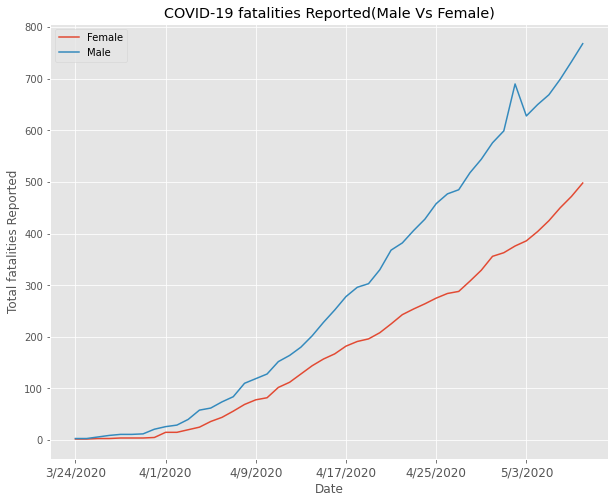

In [0]:
plt.figure(figsize=(10,8))
plt.plot(df_master['DATE'],df_master['Deaths_female_CF'], label='Female')
plt.plot(df_master['DATE'],df_master['Deaths_male_CF'], label='Male')
plt.legend(loc='best')
plt.title('COVID-19 fatalities Reported(Male Vs Female)')
plt.ylabel('Total fatalities Reported')
plt.xlabel('Date')
plt.xticks(np.arange(0, len(df), 8))
plt.xticks(fontsize = 12)
plt.show()

### There seems to be a difference in the ffatality rates between the two genders.
### This is different from the total cases reported.

## Plot 5

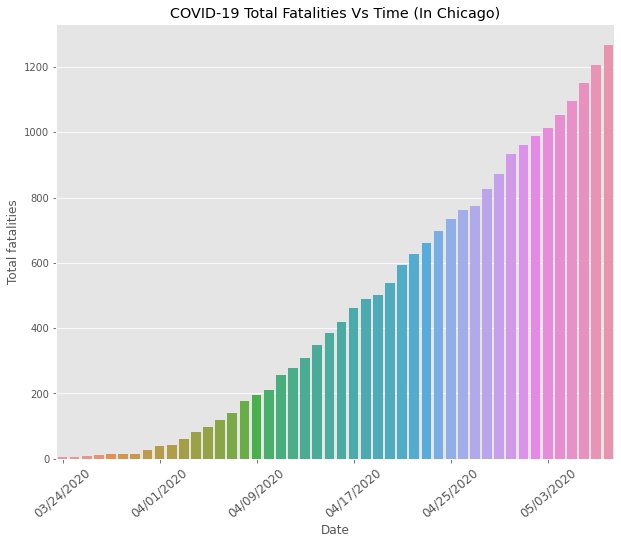

In [0]:
plt.figure(figsize=(10,8))
sns.barplot(df_master['DATE'],df_master['DEATHS_CF'])
plt.title('COVID-19 Total Fatalities Vs Time (In Chicago)')
plt.xlabel('Date')
plt.ylabel('Total fatalities')
plt.xticks(np.arange(0,len(df_master),8),
          ('03/24/2020','04/01/2020','04/09/2020','04/17/2020','04/25/2020','05/03/2020'),
           rotation = 40,fontsize = 12);
plt.show()

## Required Inference 1

In [0]:
# split data sas train and test
# train (all data except last week)
# test (last week)

def splitDataAsTrainAndTest(Y):
    return Y[0:-7], Y[-7:]

train, test = splitDataAsTrainAndTest(df)
print("Samples in Train: "+str(len(train)))
print("Samples in Train: "+str(len(test)))

Samples in Train: 39
Samples in Train: 7


In [0]:
# Error Functions (helper)
#1) MAPE 
def computeMAPE(y_pred, y):
  mape = 0
  for x in range(0,len(y)):
      temp = (abs(y[x] - y_pred[x])/y[x])
      mape += temp
  return (mape/len(y))*100

#2) SSE
def computeMeanSquaredError(y_pred, y):
    error = 0
    for x in range(0,len(y)):
        error += (np.square(y_pred[x] - y[x]))
    return error/len(y)


## Auto Regression (AR)

In [0]:
# Helper Functions
def initial_matrix(values, p):
    X_arr = []
    Y_arr = []
    # Building the X and Y matrix for multiple linear regression
    for i in range(len(values) - p):
        val = values[i:(i + p)]
        val = [1] + val
        X_arr.append(val)
        Y_arr.append(values[i + p])

    X_arr = np.array(X_arr)
    Y_arr = np.array(Y_arr)
    return X_arr, Y_arr

def solve_beta(X, Y):
    # Applying the OLS formula for finding beta coefficients vector
    Xt = np.transpose(X)
    XtX = np.dot(Xt, X)
    Xty = np.dot(Xt, Y)
    beta = np.linalg.solve(XtX, Xty)
    return beta


def auto_regression(data, p):
    X, Y = initial_matrix(data[:-7], p)
    beta = solve_beta(X, Y)
    predictions = []
    for i in range(len(data) - 7, len(data)):
        #print("Index - " + str(i) + " Data at index - " + str(data[i]))
        value = data[i - p:i]
        value = np.array([1] + value)
        x = np.dot(beta, value)
        predictions.append(x)
        #print(x)
        value = np.reshape(value, (1, p + 1))
        X = np.append(X, list(value), axis=0)
        Y = np.append(Y, data[i])
        beta = solve_beta(X, Y)
    return predictions

In [0]:
df_ar = pd.DataFrame()
df_ar['Date'] = df['DATE'][-7:]
df_ar['Actual_Cases'] = df['DEATHS'][-7:]
df_ar['Predicted_cases_AR(3)'] = auto_regression(df['DEATHS'].tolist(), 3)
df_ar['Predicted_cases_AR(5)'] = auto_regression(df['DEATHS'].tolist(), 5)
df_ar = df_ar.reset_index()
del df_ar['index']
print('PREDICTIONS USING AR(3) and AR(5)')
df_ar

PREDICTIONS USING AR(3) and AR(5)


,Date,Actual_Cases,Predicted_cases_AR(3),Predicted_cases_AR(5)
0,05/02/2020,25,38.806483,38.924545
1,05/03/2020,27,37.701722,46.692852
2,05/04/2020,40,28.394797,39.164886
3,05/05/2020,42,32.522239,38.629012
4,05/06/2020,56,34.711169,32.776743
5,05/07/2020,54,45.539289,39.095930
6,05/08/2020,62,46.682865,42.990782


In [0]:
print("Error Values for Different Values of 'n' in Auto Regression")

MSE_3 = computeMeanSquaredError(auto_regression(df['DEATHS'].tolist(), 3),  df['DEATHS'][-7:].to_list())
MSE_5 = computeMeanSquaredError(auto_regression(df['DEATHS'].tolist(), 5),  df['DEATHS'][-7:].to_list())
MAPE_3 = computeMAPE(auto_regression(df['DEATHS'].tolist(), 3),  df['DEATHS'][-7:].to_list())
MAPE_5 = computeMAPE(auto_regression(df['DEATHS'].tolist(), 5),  df['DEATHS'][-7:].to_list())

#Error Table
data = {'MSE for n=2':  [MSE_3],
        'MSE for n=5':  [MSE_5],
        'MAPE for n=3':  [MAPE_3],
        'MAPE for n=5': [MAPE_5],
        }

df_error = pd.DataFrame (data, columns = ['MSE for n=2','MSE for n=5','MAPE for n=3','MAPE for n=5'])
df_error = df_error.T
df_error.columns =['Error Value']
df_error

Error Values for Different Values of 'n' in Auto Regression


,Error Value
MSE for n=2,184.152446
MSE for n=5,245.223386
MAPE for n=3,32.118551
MAPE for n=5,34.068411


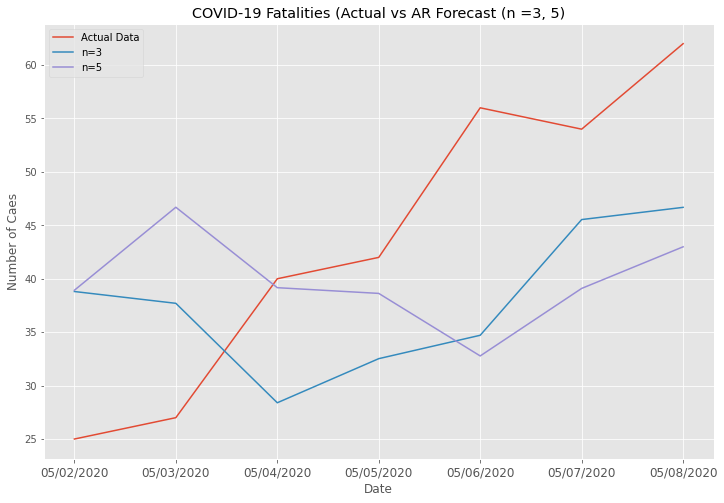

In [0]:
plt.figure(figsize=(12,8))
plt.plot(df['DATE'][-7:],df['DEATHS'][-7:], label='Actual Data')
plt.plot(df['DATE'][-7:],auto_regression(df['DEATHS'].tolist(), 3), label='n=3')
plt.plot(df['DATE'][-7:],auto_regression(df['DEATHS'].tolist(), 5),  label='n=5')
plt.legend(loc='best')
plt.title('COVID-19 Fatalities (Actual vs AR Forecast (n =3, 5)')
plt.ylabel('Number of Caes')
plt.xlabel('Date')
plt.xticks(fontsize = 12)
plt.xticks(fontsize = 12)
plt.show()

## EWMA with alpha = 0.5,0.8 (For cases Reported)

In [0]:
# Helper Functions
def EWMA(input, alpha):
  y_pred_start = input[0]
  
  y_predicted = []
  y_predicted.append(y_pred_start)
  for i in range(1,len(input)):
      y_predicted.append(alpha * input[i-1] + (1 - alpha) * y_predicted[i-1])
  
  y_actual = input
  #Compute MSE and MAPE only for test set
  MSE = computeMeanSquaredError(y_predicted[-7:], y_actual[-7:].to_list())
  MAPE = computeMAPE(y_predicted[-7:], y_actual[-7:].to_list())
  return y_predicted,MSE,MAPE

In [0]:
y_predicted_cases, MSE_predicted_cases, MAPE_predicted_cases = EWMA(df['CASES'],0.5)
y_predicted_cases_point_8,MSE_predicted_cases_point_8, MAPE_predicted_cases_point_8  = EWMA(df['CASES'],0.8)

df_ar1 = pd.DataFrame()
df_ar1['Actual_Cases'] = df['CASES'][-7:]
df_ar1['Py_predicted_casesredicted_cases_EWMA(0.5)'] = y_predicted_cases[-7:]
df_ar1['Predicted_cases_EWMA(0.8)'] = y_predicted_cases_point_8[-7:]
df_ar1 = df_ar1.reset_index()
del df_ar1['index']
print('PREDICTIONS USING EWMA(for alpha= 0.5, 0.8) for total cases reported')
df_ar1

PREDICTIONS USING EWMA(for alpha= 0.5, 0.8) for total cases reported


,Actual_Cases,Py_predicted_casesredicted_cases_EWMA(0.5),Predicted_cases_EWMA(0.8)
0,1143,1087.443371,1186.757398
1,1093,1115.221686,1151.751480
2,829,1104.110843,1104.750296
3,802,966.555421,884.150059
4,957,884.277711,818.430012
5,999,920.638855,929.286002
6,1098,959.819428,985.057200


In [0]:
print("Error Values for Different Values of Alpha in EWMA for total cases reported")
#Error Table
data = {'MSE for alpha=0.5':  [MSE_predicted_cases],
        'MSE for alpha=0.8':  [MSE_predicted_cases_point_8],
        'MAPE for alpha=0.5':  [MAPE_predicted_cases],
        'MAPE for alpha=0.8': [MAPE_predicted_cases_point_8],
        }

df_error = pd.DataFrame (data, columns = ['MSE for alpha=0.5','MSE for alpha=0.8','MAPE for alpha=0.5','MAPE for alpha=0.8'])
df_error = df_error.T
df_error.columns =['Error Value']
df_error

Error Values for Different Values of Alpha in EWMA for total cases reported


,Error Value
MSE for alpha=0.5,19552.525108
MSE for alpha=0.8,17853.009033
MAPE for alpha=0.5,12.660769
MAPE for alpha=0.8,12.064847


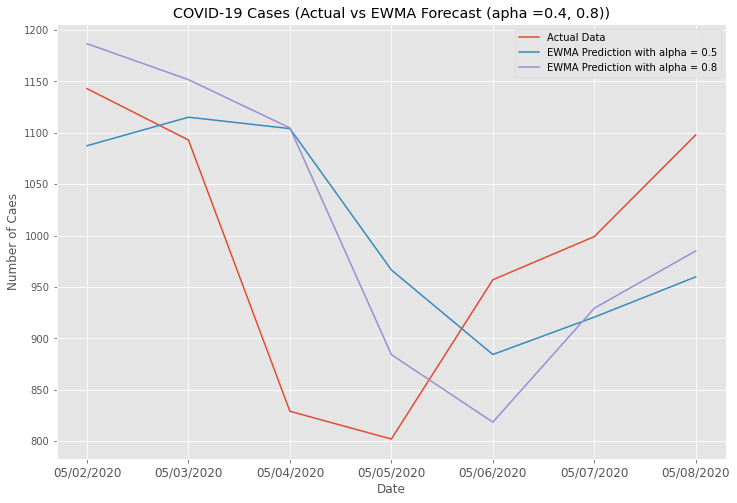

In [0]:
plt.figure(figsize=(12,8))
plt.plot(test['DATE'],test['CASES'], label='Actual Data')
plt.plot(test['DATE'],y_predicted_cases[-7:], label='EWMA Prediction with alpha = 0.5')
plt.plot(test['DATE'],y_predicted_cases_point_8[-7:], label='EWMA Prediction with alpha = 0.8')
plt.legend(loc='best')
plt.title('COVID-19 Cases (Actual vs EWMA Forecast (apha =0.4, 0.8))')
plt.ylabel('Number of Caes')
plt.xlabel('Date')
plt.xticks(fontsize = 12)
plt.xticks(fontsize = 12)
plt.show()

## EWMA with alpha = 0.5,0.8 (For fatalities Reported)

In [0]:
y_predicted_deaths, MSE_predicted_deaths, MAPE_predicted_deaths = EWMA(df['DEATHS'],0.5)
y_predicted_deaths_point_8,MSE_predicted_deaths_point_8, MAPE_predicted_deaths_point_8  = EWMA(df['DEATHS'],0.8)

df_ar2 = pd.DataFrame()
df_ar2['Actual_Deaths'] = df['DEATHS'][-7:]
df_ar2['Predicted_deaths_EWMA(0.5)'] = y_predicted_deaths[-7:]
df_ar2['Predicted_deaths_EWMA(0.8)'] = y_predicted_deaths_point_8[-7:]
df_ar2 = df_ar2.reset_index()
del df_ar2['index']
print('PREDICTIONS USING EWMA(for alpha= 0.5, 0.8) for total deaths reported')
df_ar2


PREDICTIONS USING EWMA(for alpha= 0.5, 0.8) for total deaths reported


,Actual_Deaths,Predicted_deaths_EWMA(0.5),Predicted_deaths_EWMA(0.8)
0,25,40.313055,35.308029
1,27,32.656527,27.061606
2,40,29.828264,27.012321
3,42,34.914132,37.402464
4,56,38.457066,41.080493
5,54,47.228533,53.016099
6,62,50.614266,53.803220


In [0]:
print("Error Values for Different Values of Alpha in EWMA for total fatalities reported")
#Error Table
data = {'MSE for alpha=0.5':  [MSE_predicted_deaths],
        'MSE for alpha=0.8':  [MSE_predicted_deaths_point_8],
        'MAPE for alpha=0.5':  [MAPE_predicted_deaths],
        'MAPE for alpha=0.8': [MAPE_predicted_deaths_point_8],
        }

df_error = pd.DataFrame (data, columns = ['MSE for alpha=0.5','MSE for alpha=0.8','MAPE for alpha=0.5','MAPE for alpha=0.8'])
df_error = df_error.T
df_error.columns =['Error Value']
df_error

Error Values for Different Values of Alpha in EWMA for total fatalities reported


,Error Value
MSE for alpha=0.5,129.057419
MSE for alpha=0.8,83.831907
MAPE for alpha=0.5,26.676184
MAPE for alpha=0.8,18.080089


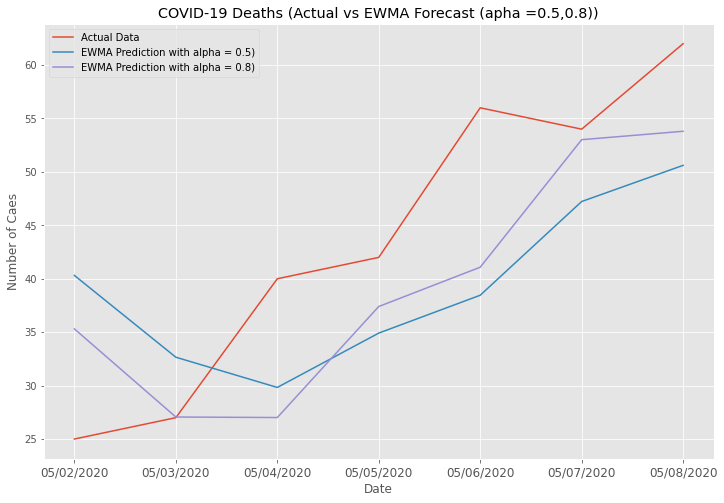

In [0]:
plt.figure(figsize=(12,8))
plt.plot(test['DATE'],test['DEATHS'], label='Actual Data')
plt.plot(test['DATE'],y_predicted_deaths[-7:], label='EWMA Prediction with alpha = 0.5)')
plt.plot(test['DATE'],y_predicted_deaths_point_8[-7:], label='EWMA Prediction with alpha = 0.8)')
plt.legend(loc='best')
plt.title('COVID-19 Deaths (Actual vs EWMA Forecast (apha =0.5,0.8))')
plt.ylabel('Number of Caes')
plt.xlabel('Date')
plt.xticks(fontsize = 12)
plt.xticks(fontsize = 12)
plt.show()

## Required Inference 2

In [0]:
# getting data of second last week data and last week data and calculating mean of cases and deaths for both weeks
# second_last_week
second_last_week = df[(df['DATE'] > '04/24/2020') & (df['DATE'] < '05/02/2020')]

# last week data
last_week = df[(df['DATE'] > '05/01/2020') & (df['DATE'] < '05/09/2020')]

In [0]:
# Poissions_distribution with mean as lambda second-last week 
#the sample mean of the second -last week data becomes lambda for poission distribution 
second_last_week_mean_death = second_last_week['DEATHS'].mean()
second_last_week_mean_cases = second_last_week['CASES'].mean()

#this second_last_week_mean becomes guess for walts estimator
#last week sample mean 
last_week_mean_death = last_week['DEATHS'].mean()
last_week_mean_cases = last_week['CASES'].mean()

#defining own variance by (n-1) as n is very small 

def variance(arr):
    square_sum = 0
    mean = arr.mean()
    n = len(arr)
    for i in arr:
        square_sum = square_sum + (i -mean)*(i-mean)
    return square_sum/(n-1)

# Walds 1 sample testing for mean of cases and death

In [0]:
#theta_hat is last_week_mean and theta_not is second_last_week_mean
#std_err is squar root of (sample mean/ lengh of data)


def walds_1_testing(last_week_mean,second_last_week_mean,last_week):
  w_1_numerator = last_week_mean - second_last_week_mean
  w_1_denominator = np.sqrt(last_week_mean/len(last_week))

  w_1_result = w_1_numerator/w_1_denominator
  return np.abs(w_1_result);


#for death calculation
w_1_result_death = walds_1_testing(last_week_mean_death,second_last_week_mean_death,last_week)
if(w_1_result_death>1.96):
  print("walds 1 sample testing for mean of death is w="+str(w_1_result_death) +" which is greater than z_alpha/2 = 1.96 so reject the NULL hypothesis")
else:
  print("walds 1 sample testing for mean of death is  w="+str(w_1_result_death)+ " which is less than z_alpha/2 = 1.96 so accept the NULL hypothesis")



#for cases calculation
w_1_result_cases = walds_1_testing(last_week_mean_cases,second_last_week_mean_cases,last_week)
if(w_1_result_cases>1.96):
  print("walds 1 sample testing for mean of cases is w="+str(w_1_result_cases) +" which is greater than z_alpha/2 = 1.96 so reject the NULL hypothesis");
else:
  print("walds 1 sample testing for mean of cases is  w="+str(w_1_result_cases)+ " which is less than z_alpha/2 = 1.96 so accept the NULL hypothesis")




walds 1 sample testing for mean of death is w=2.343813996947622 which is greater than z_alpha/2 = 1.96 so reject the NULL hypothesis
walds 1 sample testing for mean of cases is w=4.531655902207182 which is greater than z_alpha/2 = 1.96 so reject the NULL hypothesis


## Result of Walds 1 sample testing for mean of cases and death

### Null hypothesis (H0):  
Mean of last week cases/deaths = Mean of last week cases/deaths.
### Alternate hypothesis(H1): 
Mean of last week cases/deaths not equal to mean of last week cases/deaths.

### Procedure :
We have taken the guess value as mean of last second  week cases/deaths and alpha = 0.05 as given in documentation and the MLE estimator for mean of last week cases/deaths becomes the smaple mean of last week cases/deaths .The standard error of the estimator is calculated in above walds function.

## Result: 
As the w value for mean of last week death =2.343 which  is greater than 1.96  we are rejecting the NULL hypothesis.

As the w value for  meanof last week cases =4.53 which  is greater than 1.96  we are rejecting the NULL hypothesis.

# Wald's 2 sample testing

In [0]:
#Walts two sample test

#walts denominator for 2 sample

def walds_2_sample_testng(last_week_mean,second_last_week_mean,last_week,second_last_week): 
  se_death = np.sqrt(last_week_mean/len(last_week) + second_last_week_mean/len(second_last_week))
  #w value of waltz
  return ((last_week_mean-second_last_week_mean)/se_death)



#for deaths
w_2_death = walds_2_sample_testng(last_week_mean_death,second_last_week_mean_death,last_week,second_last_week)
if(w_2_death>1.96):
  print("walds 2 sample testing for mean of death is w="+str(w_2_death) +" which is greater than z_alpha/2 = 1.96 so reject the NULL hypothesis")
else:
  print("walds 2 sample testing for mean of death is  w="+str(w_2_death)+ " which is less than z_alpha/2 = 1.96 so accept the NULL hypothesis")


#for cases 
w_2_cases = walds_2_sample_testng(last_week_mean_cases,second_last_week_mean_cases,last_week,second_last_week)
if(w_2_cases>1.96):
  print("walds 2 sample testing for mean of cases is w="+str(w_2_cases) +" which is greater than z_alpha/2 = 1.96 so reject the NULL hypothesis")
else:
  print("walds 2 sample testing for mean of cases is  w="+str(w_2_cases)+ " which is less than z_alpha/2 = 1.96 so accept the NULL hypothesis")


walds 2 sample testing for mean of death is  w=1.7157965988066188 which is less than z_alpha/2 = 1.96 so accept the NULL hypothesis
walds 2 sample testing for mean of cases is w=3.24891366916799 which is greater than z_alpha/2 = 1.96 so reject the NULL hypothesis


# Result of Walds 2 sample testing for mean of cases and death

### Null hypothesis (H0):  
mean of last week cases/deaths = mean of last week cases/deaths.
### Alternate hypothesis(H1): 
mean of last week cases/deaths not equal to mean of last week cases/deaths.

### Procedure :
We have taken the  alpha = 0.05 as given in documentation and calculated the numerator and denominator of w in the above walds_2_sample_testing function  .
The standard error of the estimator is combination of the standard error of both the weeks data.

### Result: 
As the w value for  meanof last week deaths =1.76 which  is less than 1.96  we are accepting the NULL hypothesis.

As the w value for mean of last week cases =3.29 which  is greater than 1.96  we are rejecting the NULL hypothesis.


# Z-Test 

In [0]:
#have to complete this thing  true standard deviation is the stand deviation of entire covid data 

#for death

z_num_death = last_week_mean_death - second_last_week_mean_death
z_den_death = np.sqrt(variance(df[['DEATHS']].values)/len(df))

z_result_death = z_num_death/z_den_death

if(z_result_death>1.96):
  print("walds 2 sample testing for mean of death is w="+str(z_result_death) +" which is greater than z_alpha/2 = 1.96 so reject the NULL hypothesis")
else:
  print("walds 2 sample testing for mean of death is  w="+str(z_result_death)+ " which is less than z_alpha/2 = 1.96 so accept the NULL hypothesis")


#for cases
z_num_cases = last_week_mean_cases - second_last_week_mean_cases
z_den_cases = np.sqrt(variance(df[['CASES']].values)/len(df))

z_result_cases = z_num_cases/z_den_cases

if(z_result_cases>1.96):
  print("Z-Test mean of cases is w="+str(z_result_cases) +" which is greater than z_alpha/2 = 1.96 so reject the NULL hypothesis")
else:
  print("Z-test is  w="+str(z_result_cases)+ " which is less than z_alpha/2 = 1.96 so accept the NULL hypothesis")


walds 2 sample testing for mean of death is w=[2.2512774] which is greater than z_alpha/2 = 1.96 so reject the NULL hypothesis
Z-test is  w=[1.23783187] which is less than z_alpha/2 = 1.96 so accept the NULL hypothesis


#  Result of Z testing for mean of cases and death

### Null hypothesis (H0):  
 mean of last week cases/deaths = mean of last week cases/deaths.
### Alternate hypothesis(H1): 
 mean of last week cases/deaths not equal to mean of last week cases/deaths.

# Result /Inference: 
As the Calculated  Z value for  mean of last week deaths =2.25 which  is greater than 1.96  we are rejecting the NULL hypothesis.

As the Calculated Z value for mean of last week cases =1.23 which  is less than 1.96  we are accepting the NULL hypothesis.

# Is Test Applicable ?
The main Assumptions of Z-test are the sample size has to be large or the sample data has to  be normally dustributed.Here we can clearly see sample size is 7 which is very less and data is also not mormal .

Hence ,We can conclude the Z Test is not applicable on given dataset.

# T test one sample testing

In [0]:
# T test one sampling

def T_one_sample_Testing(last_week_values,last_week_mean,second_last_week_mean,last_week):
  t_1_num = last_week_mean - second_last_week_mean
  t_1_den = np.sqrt(variance(last_week_values)/len(last_week))
  return t_1_num/t_1_den

# for deaths
t_1_result_death =T_one_sample_Testing(last_week[['DEATHS']].values,last_week_mean_death,second_last_week_mean_death,last_week)
if(t_1_result_death>2.45):
  print("walds 1 sample testing for mean of death is T_1="+str(t_1_result_death) +" which is greater than t(6,alpha/2) = 2.45 so reject the NULL hypothesis")
else:
  print("walds 1 sample testing for mean of death is  T_1="+str(t_1_result_death)+ " which is less than t(6,alpha/2) = 2.45 so accept the NULL hypothesis")


# for cases
t_1_result_cases =T_one_sample_Testing(last_week[['CASES']].values,last_week_mean_cases,second_last_week_mean_cases,last_week)
if(t_1_result_cases>2.45):
  print("T-Test 1 sample testing for mean of cases is T_1="+str(t_1_result_cases) +" which is greater than t(6,alpha/2) = 2.45 so reject the NULL hypothesis")
else:
  print("T-Test 1 sample testing for mean of cases is  T_1="+str(t_1_result_cases)+ " which is less than t(6,alpha/2) = 2.45so accept the NULL hypothesis")


walds 1 sample testing for mean of death is  T_1=[1.07907192] which is less than t(6,alpha/2) = 2.45 so accept the NULL hypothesis
T-Test 1 sample testing for mean of cases is  T_1=[1.06155916] which is less than t(6,alpha/2) = 2.45so accept the NULL hypothesis


#  Result of T 1 sample testing for mean of cases and death

### Null hypothesis (H0):  
mean of last week cases/deaths = mean of last week cases/deaths.
### Alternate hypothesis(H1): 
 mean of last week cases/deaths not equal to mean of last week cases/deaths.

### Procedure :
We have taken the  alpha = 0.05,n =7 as we took 7 days of data as given in documentation and calculated the numerator and denominator of T  in the above T_one_sample_testing function  .

### Result: 
As the calculated  value for mean of last week deaths =1.08 which  is less than T value 2.45  we are accepting the NULL hypothesis.

As the calculated  value for mean of last week cases =1.06 which  is less than T value 2.45  we are accepting the NULL hypothesis.

### Is T-1 sample  Test Applicable ?

The main ssumption of T-test is the data is normally distributed but hereit is not Hence the test is not applicable

# T two Sample paired Testing

### Calculating new dataset by difference of last_week  data and second_last_week data and then calling the T two sample paired Test function

In [0]:
#lets get make other datatset from second_last_week deaths last_week deaths say diff_week_deaths

#### deaths 
diff_week_death= last_week[['DEATHS']]- second_last_week[['DEATHS']].values
diff_week_death = diff_week_death.reset_index()
del diff_week_death['index']

#sample mean for different deaths
diff_week_mean_death = diff_week_death['DEATHS'].mean()

##### var for different deaths
diff_week_variance_death =(variance(diff_week_death[['DEATHS']].values))

last_week

diff_week_cases= last_week[['CASES']]- second_last_week[['CASES']].values

diff_week_cases = diff_week_cases.reset_index()
del diff_week_cases['index']

diff_week_cases

#sample mean for different deaths
diff_week_mean_cases = diff_week_cases['CASES'].mean()

##### var for different deaths
diff_week_variance_cases =(variance(diff_week_cases[['CASES']].values))

In [0]:
# now we calculate sample mean and standard deviation of diff_week_deaths


#sample variance
#diff_week_deaths_variance =vari(second_last_week[['DEATHS']].values)
def T_two_sample_testing(diff_value,diff_mean ,diff_var):
  diff_num = diff_mean
  diff_den = np.sqrt(diff_var/len(diff_value))
  return np.abs(diff_num/diff_den)


#paired T test result
paired_t_res_death = T_two_sample_testing(diff_week_death,diff_week_mean_death,diff_week_variance_death)
if(paired_t_res_death>2.45):
  print("T two sample paired  testing for mean of death is T="+str(paired_t_res_death) +" which is greater than t(6,alpha/2) = 2.45 so reject the NULL hypothesis")
else:
  print("T two sample paired  testing for mean of death is  T="+str(paired_t_res_death)+ " which is less than t(6,alpha/2) = 2.45 so accept the NULL hypothesis")




#paired T test result
paired_t_res_cases = T_two_sample_testing(diff_week_cases,diff_week_mean_cases,diff_week_variance_cases)
if(paired_t_res_cases>2.45):
  print("T two sample paired  testing for mean of cases is T="+str(paired_t_res_cases) +" which is greater than t(6,alpha/2) = 2.45 so reject the NULL hypothesis")
else:
  print("T two sample paired  testing for mean of cases is  T="+str(paired_t_res_cases)+ " which is less than t(6,alpha/2) = 2.45 so accept the NULL hypothesis")




T two sample paired  testing for mean of death is  T=[0.86699299] which is less than t(6,alpha/2) = 2.45 so accept the NULL hypothesis
T two sample paired  testing for mean of cases is  T=[0.69251878] which is less than t(6,alpha/2) = 2.45 so accept the NULL hypothesis


##  Result of T 2 sample paired testing for mean of cases and death

### Null hypothesis (H0):  
mean of last week cases/deaths = mean of last week cases/deaths.
### Alternate hypothesis(H1): 
mean of last week cases/deaths not equal to mean of last week cases/deaths.

# Procedure :
We have taken the  alpha = 0.05 n=7 as given in documentation and calculated the numerator and denominator of T value in the above T_two_sample_testing function  .

# Result: 
As the T_two_sample_testing value for  mean of last week deaths =0.86 which  is less than 2.45  we are accepting the NULL hypothesis.

As the T_two_sample_testing value for mean of last week cases = 0.7 which  is less than 2.45 we are accpeting the NULL hypothesis.


### Is the paired T Test appliable ?
Paired T-Test Assumes that the data X and Y are dependent and diff of(X,Y) data set is normally distributed and as these two assumptions are failing Paired T test is not applicable.




# T two sample unpaired testing

In [0]:
### death
# T_2_u numerator is difference of sample mean
T_2_u_num_death = second_last_week_mean_death - last_week_mean_death

#T_2_U denominator is sqrt of sum of the variance 
second_last_week_variance_death = variance(second_last_week[['DEATHS']].values)
last_week_variance_death = variance(last_week[['DEATHS']].values)
T_2_u_den_death = np.sqrt(last_week_variance_death/len(last_week) + second_last_week_variance_death/len(second_last_week))

#T test unpaired result
T_unpaired_result_death = np.abs(T_2_u_num_death/T_2_u_den_death)

if(T_unpaired_result_death>2.18):
  print("T two sample unpaired  testing for mean of death is T="+str(T_unpaired_result_death) +" which is greater than t(12,alpha/2) = 2.18 so reject the NULL hypothesis")
else:
  print("T two sample unpaired  testing for mean of death is  T="+str(T_unpaired_result_death)+ " which is less than t(12,alpha/2) = 2.18 so accept the NULL hypothesis")


### Cases
# T_2_u numerator is difference of sample mean
T_2_u_num_cases = second_last_week_mean_cases - last_week_mean_cases

#T_2_U denominator is sqrt of sum of the variance 
second_last_week_variance_cases = variance(second_last_week[['CASES']].values)
last_week_variance_cases = variance(last_week[['CASES']].values)
T_2_u_den_cases = np.sqrt(last_week_variance_cases/len(last_week) + second_last_week_variance_cases/len(second_last_week))

#T test unpaired result
T_unpaired_result_cases = np.abs(T_2_u_num_cases/T_2_u_den_cases)

if(T_unpaired_result_cases>2.18):
  print("T two sample unpaired  testing for mean of cases is T="+str(T_unpaired_result_cases) +" which is greater than t(12,alpha/2) = 2.18 so reject the NULL hypothesis")
else:
  print("T two sample unpaired  testing for mean of cases is  T="+str(T_unpaired_result_cases)+ " which is less than t(12,alpha/2) = 2.18 so accept the NULL hypothesis")

T two sample unpaired  testing for mean of death is  T=[0.71375444] which is less than t(12,alpha/2) = 2.18 so accept the NULL hypothesis
T two sample unpaired  testing for mean of cases is  T=[0.5759669] which is less than t(12,alpha/2) = 2.18 so accept the NULL hypothesis


#  Result of T 2 sample unpaired testing for mean of cases and death

### Null hypothesis (H0):  
mean of last week cases/deaths = mean of last week cases/deaths.
### Alternate hypothesis(H1): 
mean of last week cases/deaths not equal to mean of last week cases/deaths.

# Procedure :
We have taken the  alpha = 0.05 n=7, m=7as given in documentation and calculated the numerator and denominator of T value in the above T_two_sample_testing function  .

# Result: 
As the T_two_sample_testing value for mean of last week cases = 0.62 which  is less than 2.18 we are accpeting the NULL hypothesis.

As the T_two_sample_testing value for  mean of last week deaths =0.77 which  is less than 2.18 we are accepting the NULL hypothesis.

## Required Inference 3

Repeat inference 2 above but for equality of distributions (distribution of second-last week and last week), using K-S test and Permutation test. For the K-S test, use both 1-sample and 2-sample tests. For the 1-sample test, try Poisson, Geometric, and Binomial. To obtain parameters of these distributions to check against in 1-sample KS, use MME on second last week’s data to obtain parameters of the distribution, and then check whether the last week’s data has the distribution with the obtained MME



Fetching second last week data



In [0]:
second_last_week = df[(df['DATE'] > '04/17/2020') & (df['DATE'] < '04/25/2020')]
second_last_week_deaths = second_last_week['DEATHS'].tolist()
second_last_week_deaths = second_last_week['CASES'].tolist()

Fetching required values for using MME


In [0]:
second_last_week['X_bar_deaths'] = second_last_week['DEATHS'].mean()
second_last_week['X_bar_cases'] = second_last_week['CASES'].mean()
second_last_week['X-Xbar_square_deaths'] = (second_last_week['DEATHS'] - second_last_week['X_bar_deaths'])*(second_last_week['DEATHS'] - second_last_week['X_bar_deaths'])
second_last_week['X-Xbar_square_cases'] = (second_last_week['CASES'] - second_last_week['X_bar_cases'])*(second_last_week['CASES'] - second_last_week['X_bar_cases'])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

Fetching last week data


In [0]:
last_week =df[(df['DATE'] > '04/24/2020') & (df['DATE'] < '05/02/2020')]
last_week_deaths = last_week['DEATHS'].tolist()
last_week_deaths = last_week['CASES'].tolist()

#1 sample test


In [0]:
def getval(X1, Y1, start1):

    ret = 0
    for i in range(len(X1)):
        if X1[i] < start1:
            continue
        elif X1[i] == start1:
            return Y1[i]
        else:
            return Y1[i-1]
    return ret

In [0]:
def get_cdf_1sample(list_values):
    list_values.sort()
    value_1 = 1/len(list_values)
    cdf_1 = value_1

    deaths_1_cdf ={}

    for i in list_values:
        deaths_1_cdf[i] = cdf_1
        cdf_1 +=value_1
        
    return deaths_1_cdf

In [0]:
def ks_test_1sample(list1, list2, dist, casesORdeaths):

    maxVal = 0
    maxX = 0
    
    X = []
    Y = []
    for key, value in list1.items():
        X.append(key)
        Y.append(value)
    
    start1 = min(last_week['DEATHS'])
    end1 = max(last_week['DEATHS'])+1

    if casesORdeaths == 'deaths':
        start1 = min(last_week['DEATHS'])
        end1 = max(last_week['DEATHS'])+1
    else:
        start1 = min(last_week['CASES'])
        end1 = max(last_week['CASES'])

    while start1<end1:
        temp = abs(list2[start1]-getval(X,Y,start1))
        if temp>maxVal:
            maxVal = temp
            maxX = (start1)
        start1+=1
    
    X1 = []
    Y1 = []
    for key, value in list2.items():
        X1.append(key)
        Y1.append(value)

    
    plt.figure('K-S test for '+ dist , figsize=(20,7))
    plt.xlabel(dist + " distribution")
    plt.ylabel('Cumulative distribution frequency')
    
    plt.step(X, Y, where='post', label="last week")
    plt.step(X1, Y1, where='post', label="second last week")
    
    plt.vlines(x=maxX, ymin = getval(X, Y, maxX), ymax =getval(X1, Y1,maxX))
    plt.text(maxX+1,maxVal*0.7,"{:.4f}".format(maxVal),rotation=90)
    plt.legend(loc="upper left")
    plt.grid()
    plt.show()
    
    
    print("K-S statistic is " + str(maxVal)+" and point of max difference is "+str(maxX))


# Parameters computed using MME




In [0]:
#Lamba values deaths
deaths_poisson_lambda = second_last_week['X_bar_deaths'].mean()
deaths_geometric_lamba = 1/second_last_week['X_bar_deaths'].mean()
deaths_binomial_p = 1 - (sum(second_last_week['X-Xbar_square_deaths'])/(second_last_week['X_bar_deaths'].mean()*7))
deaths_binomial_n = second_last_week['X_bar_deaths'].mean()/deaths_binomial_p
print("lambda value for poisson distribution of deaths" + str(deaths_poisson_lambda))
print("lambda value for geometric distribution of deaths" +str(deaths_geometric_lamba))
print("p value for binomial distribution of deaths" + str(deaths_binomial_p))
print("n value for binomial distribution of deaths" + str(deaths_binomial_n))



lambda value for poisson distribution of deaths33.714285714285715
lambda value for geometric distribution of deaths0.029661016949152543
p value for binomial distribution of deaths-3.2094430992736074
n value for binomial distribution of deaths-10.504715201810638


In [0]:
#Lamba values cases
cases_poisson_lambda = second_last_week['X_bar_cases'].mean()
cases_geometric_lamba = 1/second_last_week['X_bar_cases'].mean()
cases_binomial_p = 1 - (sum(second_last_week['X-Xbar_square_cases'])/(second_last_week['X_bar_cases'].mean()*7))
cases_binomial_n = second_last_week['X_bar_cases'].mean()/deaths_binomial_p
print("lambda value for poisson distribution of cases" + str(cases_poisson_lambda))
print("lambda value for geometric distribution of cases" +str(cases_geometric_lamba))
print("p value for binomial distribution of cases" + str(cases_binomial_p))
print("n value for binomial distribution of cases" + str(cases_binomial_n))

lambda value for poisson distribution of cases688.142857142857
lambda value for geometric distribution of cases0.001453186630682998
p value for binomial distribution of cases-43.48554227586822
n value for binomial distribution of cases-214.41192003017727


# Poisson distribution


In [0]:
def poisson(x, lam):
    return (lam**x/math.factorial(x)) * np.exp(-lam)

def poisson_cdf( lam, x):
    sum1 = 0
    i = 0
    while i<=x+1:
        sum1 += poisson(i,lam)
        i+=1
    
    return sum1


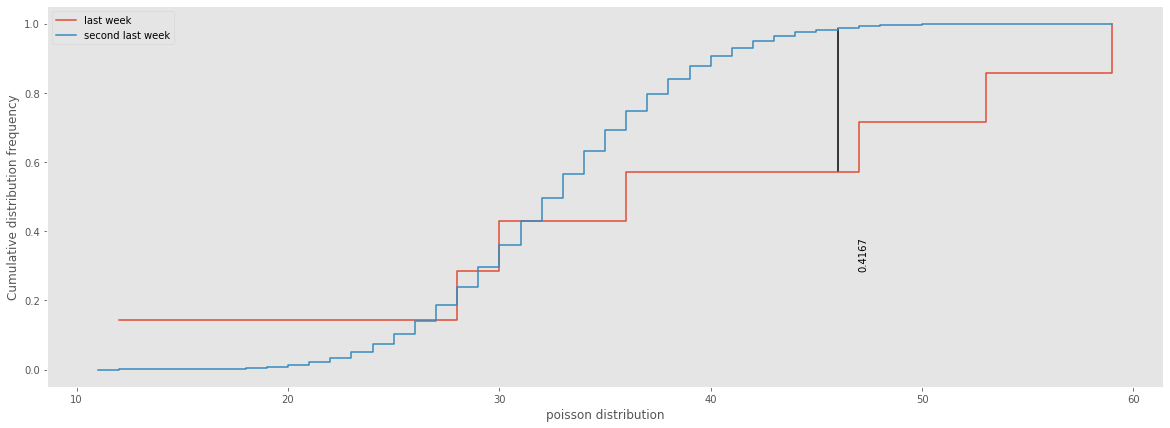

K-S statistic is 0.4167265256826834 point of max difference is 46


In [0]:
poisson_deaths_cdf_new = {}

start = min(last_week['DEATHS'])-1
end = max(last_week['DEATHS'])+1
# print(deaths_poisson_lambda)
while(start<end):
    poisson_deaths_cdf_new[start] = poisson_cdf(deaths_poisson_lambda,start)
    start+=1

# print(poisson_cases_cdf_new)
ourcdf = get_cdf_1sample(last_week['DEATHS'].tolist())

ks_test_1sample(ourcdf, poisson_deaths_cdf_new, "poisson","deaths")


##  Result of 1 sample KS test for last week deaths with poisson distribution

### Null hypothesis (H0): 
Distribution of last week deaths equals poisson distribution
### Alternate hypothesis(H1): 
Distribution of last week deaths not equals poisson distribution

# Procedure :
We have obtained parameters for poisson distribution by using MME on second last week data.
We have taken the  c = 0.05 and n=7 as given in documentation and calculated the maximum difference of the CDF of the distributions at all the points.

# Result: 

As the KS test value for mean of last week deaths =0.416 which  is greater than 0.05 we are rejecting the NULL hypothesis.



### Is the KS Test appliable ?
There as no assumptions under KS test, hence the test is applicable 





In [0]:
poisson_cases_cdf_new = {}

start = min(last_week['CASES'])-1
end = max(last_week['CASES'])+1
while(start<end):
    poisson_cases_cdf_new[start] = poisson_cdf(cases_poisson_lambda,start)
    start+=1

# print(poisson_cases_cdf_new)
ourcdf = get_cdf_1sample(last_week['CASES'].tolist())

ks_test_1sample(ourcdf, poisson_cases_cdf_new, "poisson",cases)

OverflowError: ignored

#Result of 1 sample KS test for last week cases with poisson distribution

Was unable to evaluate the factorial for very large values




# Geometric



In [0]:
def geometric(p,x):
    return (p*((1-p)**(x-1)))


def geometric_cdf(p,x):
    return (1-(1-p)**(x+1))

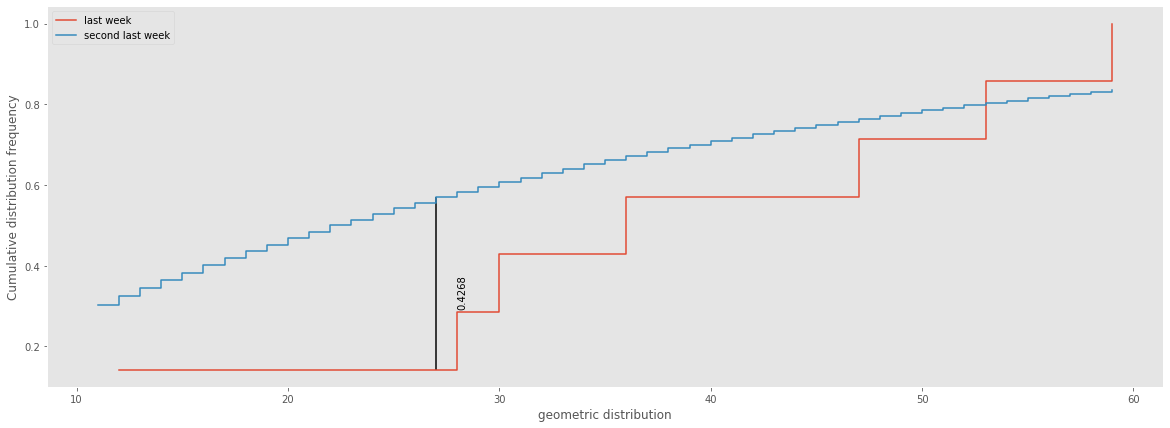

K-S statistic is 0.4267575641174432 point of max difference is 27


In [0]:
geometric_deaths_cdf_new = {}
  
start = min(last_week['DEATHS'])-1
end = max(last_week['DEATHS'])+1

while(start<end):
    geometric_deaths_cdf_new[start] = geometric_cdf(deaths_geometric_lamba,start)
    start+=1


ourcdf = get_cdf_1sample(last_week['DEATHS'].tolist())

ks_test_1sample(ourcdf, geometric_deaths_cdf_new, "geometric", "deaths")


##  Result of 1 sample KS test for last week deaths with geometric distribution

### Null hypothesis (H0): 
Distribution of last week deaths equals geometric distribution
### Alternate hypothesis(H1): 
Distribution of last week deaths not equals geometric distribution

# Procedure :
We have obtained parameters for geometric distribution by using MME on second last week data.
We have taken the  c = 0.05 and n=7 as given in documentation and calculated the maximum difference of the CDF of the distributions at all the points.


# Result: 
As the KS test value for mean of last week deaths =0.426 which  is greater than 0.05 we are rejecting the NULL hypothesis.



### Is the KS Test appliable ?
There as no assumptions under KS test, hence the test is applicable 





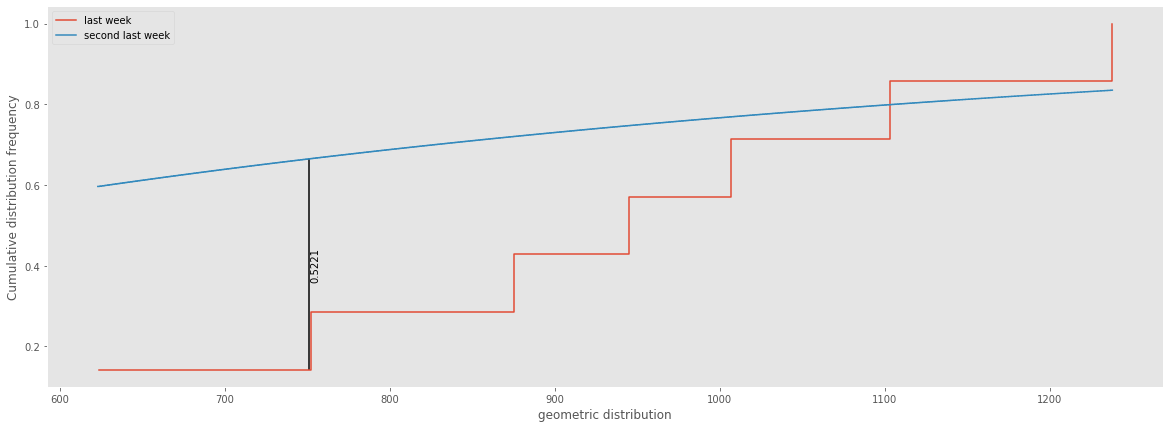

K-S statistic is 0.5221315968378604 point of max difference is 751


In [0]:
geometric_cases_cdf_new = {}
  
start = min(last_week['CASES'])-1
end = max(last_week['CASES'])+1

while(start<end):
    geometric_cases_cdf_new[start] = geometric_cdf(cases_geometric_lamba,start)
    start+=1

# print(geometric_cases_cdf_new)
ourcdf = get_cdf_1sample(last_week['CASES'].tolist())
# print(ourcdf)

ks_test_1sample(ourcdf, geometric_cases_cdf_new, "geometric","cases")


##  Result of 1 sample KS test for last week cases with geometric distribution

### Null hypothesis (H0): 
Distribution of last week cases equals geometric distribution
### Alternate hypothesis(H1): 
Distribution of last week cases not equals geometric distribution


# Procedure :
We have obtained parameters for geometric distribution by using MME on second last week data.
We have taken the  c = 0.05 and n=7 as given in documentation and calculated the maximum difference of the CDF of the distributions at all the points.

# Result: 
As the KS test value for mean of last week deaths =0.58 which  is greater than 0.05 we are rejecting the NULL hypothesis.


### Is the KS Test appliable ?
There as no assumptions under KS test, hence the test is applicable 





# Binomial


In [0]:
def binomial(n,p,x):
    return (choose(n, k) * p**k * (1-p)**(n-k))

def binomial_cdf(n,p,x):
    sum1 = 0
    i = 0
    while i<=x+1:
        sum1 += binomial(n,p,i)
        i+=1
    return sum1

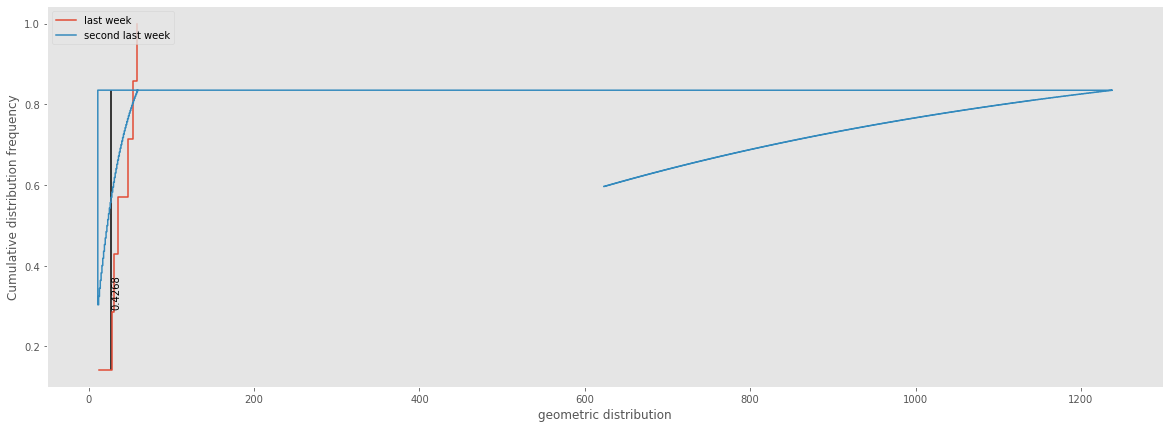

K-S statistic is 0.4267575641174432 point of max difference is 27


In [0]:
binomial_deaths_cdf_new = {}
  
start = min(last_week['DEATHS'])-1
end = max(last_week['DEATHS'])+1

while(start<end):
    binomial_deaths_cdf_new[start] = geometric_cdf(deaths_geometric_lamba,start)
    start+=1


ourcdf = get_cdf_1sample(last_week['DEATHS'].tolist())

ks_test_1sample(ourcdf, binomial_deaths_cdf_new, "geometric","deaths")

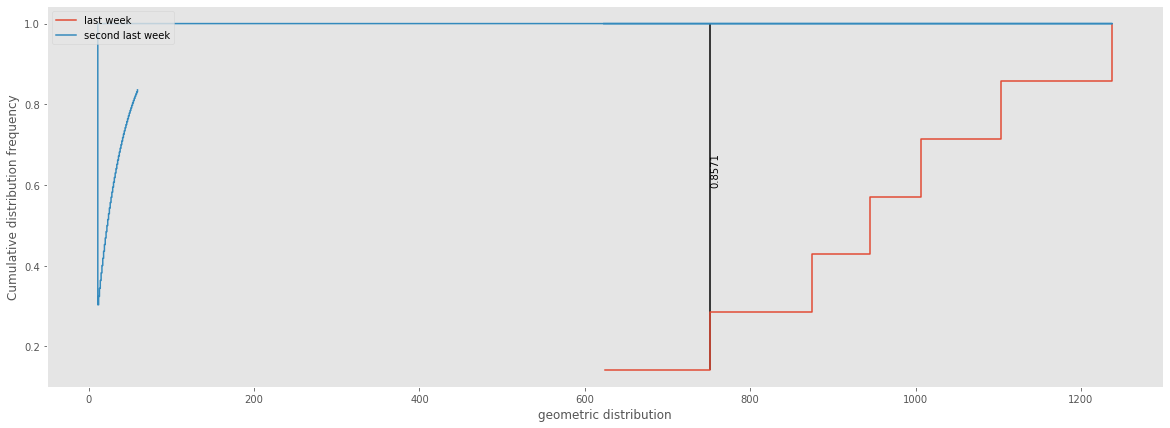

K-S statistic is 0.8571428569961483 point of max difference is 751


In [0]:
binomial_cases_cdf_new = {}
  
start = min(last_week['CASES'])-1
end = max(last_week['CASES'])+1

while(start<end):
    geometric_cases_cdf_new[start] = geometric_cdf(deaths_geometric_lamba,start)
    start+=1


ourcdf = get_cdf_1sample(last_week['CASES'].tolist())

ks_test_1sample(ourcdf, geometric_cases_cdf_new, "geometric","cases")

In [0]:
print("")

p and n values for binomial distribution are negative in both distributions. Hence the 

# 2 Sample test



In [0]:
deaths_last_week= last_week['DEATHS'].tolist()
deaths_second_last_week = second_last_week['DEATHS'].tolist()

cases_last_week = last_week['CASES'].tolist()
cases_second_last_week = second_last_week['CASES'].tolist()

print(deaths_last_week)
print(deaths_second_last_week)
print(cases_last_week)
print(cases_second_last_week)

[36, 28, 12, 53, 47, 59, 30]
[27, 12, 38, 55, 34, 34, 36]
[1103, 624, 752, 945, 875, 1007, 1238]
[652, 536, 429, 612, 794, 993, 801]


In [0]:
def get_cdf(list_values):
    list_values.sort()
    value_1 = 1/len(list_values)
    cdf_1 = value_1

    deaths_1_cdf ={}

    for i in list_values:
        deaths_1_cdf[i] = cdf_1
        cdf_1 +=value_1
        
    return deaths_1_cdf

In [0]:
def ks_test(list1, list2):
    list1_cdf = get_cdf(list1)
    list2_cdf = get_cdf(list2)

    i=0
    j=0
    maxi1=0
    while i<len(list1) and j<len(list2):
        if list1[i] < list2[j]:
            if j==0:
                F_x_cap=0
            else:
                F_x_cap = list2_cdf[list2[j-1]]
            if i==0:
                F_y_left=0
            else:
                F_y_left = list1_cdf[list1[i-1]]
            if i==len(list1)-1:
                F_y_right=1
            else:
                F_y_right=list1_cdf[list1[i]]
            maxi_temp=max(abs(F_x_cap-F_y_left),abs(F_x_cap-F_y_right))
            if maxi_temp>maxi1:
                maxi1=maxi_temp
                index=i
            i+=1
        else:
            j+=1
    
        
    X1 = []
    Y1 = []
    for key, value in list2_cdf.items():
        X1.append(key)
        Y1.append(value)
    
    X = []
    Y = []
    for key, value in list1_cdf.items():
        X.append(key)
        Y.append(value)
        
    plt.figure('K-S test' , figsize=(20,7))
    # plt.xlabel("XXXXXXXXXXX distribution")
    plt.ylabel('Cumulative distribution frequency')
    
    plt.step(X, Y, where='post', label="last week")
    plt.step(X1, Y1, where='post', label="second last week")
    
#     print(X1)
# #     print(index)
#     print(X1[index+1])

#     print(list2_cdf[X1[index+1]])
#     print(list2_cdf[list1[index]])
#     print(list1_cdf[list1[index]] + maxi1)
    
    # plt.vlines(x=list1[index], ymin = list1_cdf[list1[index]], ymax =list1_cdf[list1[index]] + maxi1)
#     plt.text(maxX+1,maxVal*1,"{:.4f}".format(maxVal),rotation=90)
#     plt.legend(loc="upper left")
    # plt.title("Posterior gamma distributions with their MAP(mean) values")
    plt.grid()
    plt.show()
    print("K-S statistic is " + str(maxi1)+" and point of max difference is "+str(list1[index]))
    return maxi1


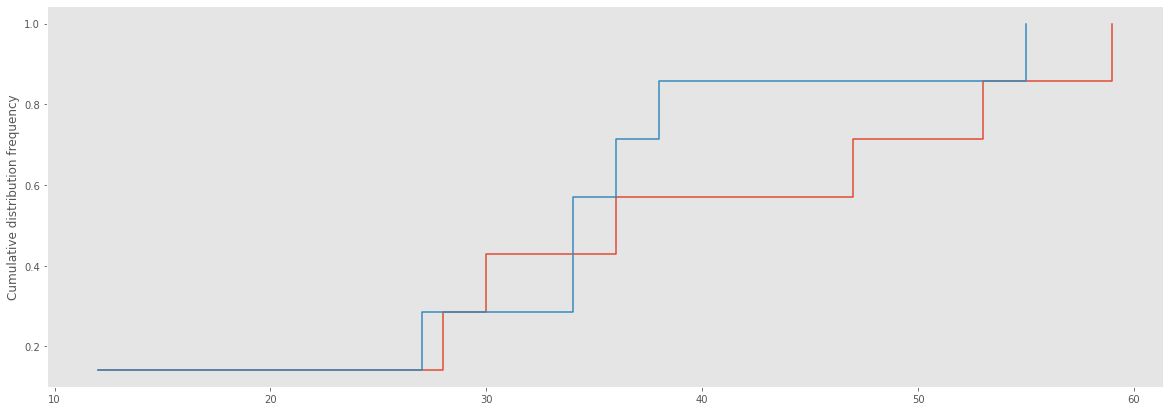

K-S statistic is 0.28571428571428564 and point of max difference is 36


In [0]:
KS_p_value_deaths = ks_test(deaths_last_week, deaths_second_last_week)
# print(KS_p_value_deaths)


##  Result of 2 sample KS test for last week and second last week deaths


### Null hypothesis (H0): 
Distribution of last week deaths equals  distribution of second last week deaths
### Alternate hypothesis(H1): 
Distribution of last week deaths not equals to distribution of second last week deaths

# Procedure :
We have taken the  c = 0.05, n=7 as given in documentation and calculated the maximum difference of the CDF of the distributions at all the points.

# Result: 
As the KS test value for mean of last week deaths =0.28 which  is greater than 0.05 we are rejecting the NULL hypothesis.


### Is the KS Test appliable ?
There as no assumptions under KS test, hence the test is applicable 






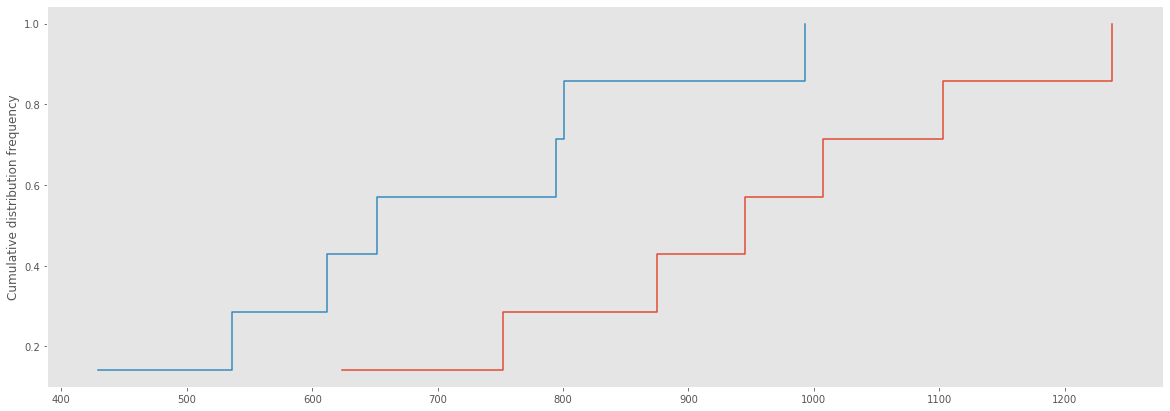

K-S statistic is 0.5714285714285713 and point of max difference is 875


In [0]:
KS_p_value_cases = ks_test(cases_last_week, cases_second_last_week)


To check if the two data samples follow the same distribution


##  Result of 2 sample KS test for last week and second last week cases

### Null hypothesis (H0): 
Distribution of last week equals  distribution of second last week
### Alternate hypothesis(H1): 
Distribution of last week not equals to distribution of second last week

# Procedure :
We have taken the  c = 0.05, n=7 as given in documentation and calculated the maximum difference of the CDF of the distributions at all the points.

# Result: 
As the KS test value for mean of last week deaths =0.57 which  is greater than 0.05 we are rejecting the NULL hypothesis.

### Is the KS Test appliable ?
There as no assumptions under KS test, hence the test is applicable 





# Permutation test


In [0]:
def perm_test(list1, list2, rounds):
    count =0
    perm_diff = abs(np.mean(list1) - np.mean(list2))
    # print("diff :" + str(perm_diff))
    list_final = list1+list2
    # print(list_final)
    n = len(list_final)
    for i in range(0,rounds):
        s1=np.random.permutation(list_final)[:n//2]
        s2=np.random.permutation(list_final)[n//2:]
        # print(abs(s1.mean() - s2.mean()))
        if (abs(s1.mean() - s2.mean())>perm_diff):
            count+=1

    return (count/rounds)

In [0]:
# print(cases_last_week)
# print(cases_second_last_week)
# print(deaths_last_week)
# print(deaths_second_last_week)

In [0]:
PERM_p_value_cases = perm_test(cases_last_week, cases_second_last_week, 1000)
print("p value "+ str(PERM_p_value_cases))

p value 0.001


To check if the two data samples follow the same distribution

##  Result of Permutation test for last week and second last week cases

### Null hypothesis (H0): 
Distribution of last week cases equals distribution of second last week cases

### Alternate hypothesis(H1): 
Distribution of last week cases not equals to distribution of second last week cases



# Procedure :
We have permutated all the last week and second last week data in 1000 ways. 
We have taken the  alpha = 0.05, N=14 as given in documentation and calculated  

# Result: 
As the Permutation test value for mean of last week deaths =0.002 which  is less than 0.05 we are accepting the NULL hypothesis.


### Is the Permutation Test appliable ?

There as no assumptions under KS test, hence the test is applicable 






In [0]:
PERM_p_value_deaths = perm_test(deaths_last_week, deaths_second_last_week, 1000)
print("p value "+ str(PERM_p_value_deaths))

p value 0.434


In [0]:
print(PERM_p_value_cases) #cases different dist
print(PERM_p_value_deaths) #deaths same dist

0.005
0.434


To check if the two data samples follow the same distribution

##  Result of Permutation test for last week and second last week deaths

### Null hypothesis (H0): 
Distribution of last week deaths equals distribution of second last week deaths

### Alternate hypothesis(H1): 
Distribution of last week deaths not equals to distribution of second last week deaths

# Procedure :
We have permutated all the last week and second last week data in 1000 ways. 
We have taken the  alpha = 0.05, N=14 as given in documentation and calculated  

# Result: 
As the Permutation test value for mean of last week deaths =0.472 which  is greater than 0.05 we are rejecting the NULL hypothesis.


### Is the KS Test appliable ?
There as no assumptions under Permutation test, hence the test is applicable 







## Required Inference 4

In [0]:
# helper function to compute correlation
def computeCorrelation(x,y):
  x_mean = np.mean(x)
  y_mean = np.mean(y)

  xy = 0
  xi_x = 0
  yi_y = 0

  for i in range(len(x)):
    xy += ((x[i]-x_mean) * (y[i] - y_mean))
    xi_x += np.square(x[i] - x_mean)
    yi_y += np.square(y[i] - y_mean)
  
  return xy/((np.sqrt(xi_x * yi_y)))


In [0]:
x = zoom_df['Price']
y = zoom_df['DEATHS']
correlation = computeCorrelation(x,y)
#validate it with corr
print("Our Function Correlation: %1.3f " % (correlation))
print("Python inbuilt Correlation: %1.3f " % (x.corr(y)))


In [0]:
figure, ax = plt.subplots(figsize=(10,8))
ax2 = ax.twinx()
ax.plot(zoom_df['Price'], label="price")
ax.set_xlabel('Days Passed since March 24th(Ignoring days when there was no trading) ',fontsize = 12)
ax.set_ylabel('Zoom Stock Price')
ax2.plot(zoom_df['CASES_CF'], color="C2", label="Cases")
ax2.set_ylabel('COVID-19 Cases ')
ax.set_title('COVID-19 Cases Reported in Chicago')
ax.legend(loc=2)
ax2.legend(loc=4)
plt.show()

# Result

We have used zoom's stock price as our X-data set to see the correlation between the Number of Covid-19 cases reported and how did the Zoom's Stock price has been efffected by this pandemic.

## We got a correlation of 0.23

This is neither a too strong nor too weak correlation.

We were expecting an even stronger correlation as our hypothesis was that, due to the COVID-19 pandemic more people are shifting towards online video conferencing apps like Zoom.

This should increase it's stock price, but a few extra events like security vulnerabilities in Zoom, competition from Facebook and Google Hangouts brought the price down, which we did not account for.

So,our correlation is actually a reasonable estimate, as it captures the fact that price was not as high as we expected(due to the reasons mentioned above), and that was confirmed with our correlation value of 0.23 (<0.5) which is not a strong correlation.

## Required Inference 5

plotting gamma distribution for week 1 , week 2, week 3 , week 4.
MAP values for gamma distribution are the mean values since mode cannot be computed.
These MAP values have been marked in the plot.



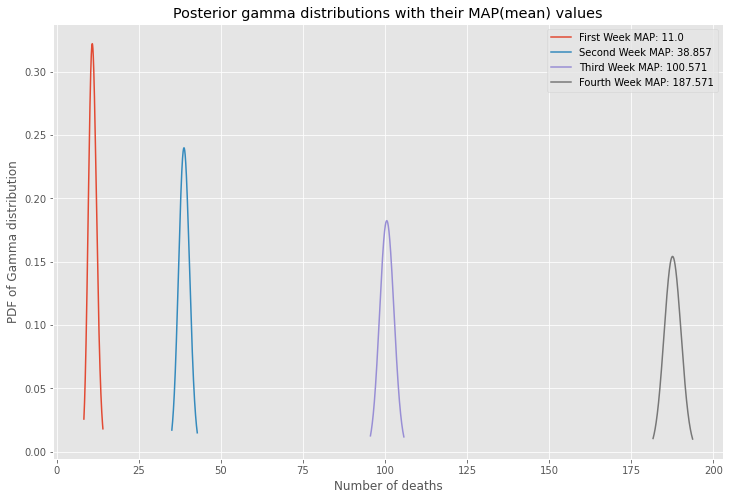

In [0]:

colnames = ['date', 'cases', 'deaths']
#use this while running locally
#data = pd.read_csv('dataset/covid_data.csv', names=colnames)
data = pd.read_csv('covid_data.csv', names=colnames)
date=list(data['date'][1:])
cases=list(data['cases'][1:])
deaths=list(data['deaths'][1:])
deaths_5=[]
for i in deaths:
	if ',' in i:
		i=i.replace(',','')
	deaths_5.append(int(i))
#print(deaths_5)
def plot_gamma(alpha=1, beta=1, label="0"):
  x = np.linspace(gamma.ppf(0.01, alpha, scale=1/beta),
                      gamma.ppf(0.99, alpha, scale=1/beta), 1000)
  
  plt.title("Posterior gamma distributions with their MAP(mean) values")
  label= label + "MAP: " + str(round((alpha/beta),3))
  plt.plot(x, gamma.pdf(x, alpha, scale=1/beta), label=label)
  plt.xlabel("Number of deaths")
  plt.ylabel("PDF of Gamma distribution")
  plt.legend()

plt.figure(figsize=(12,8))
plot_gamma(sum(deaths_5[:7])+1,len(deaths_5[:7]) + len(deaths_5[:7])/sum(deaths_5[:7]),'First Week ') # str(len(deaths_5[:7])) + " MAP: " + str((sum(deaths_5[:7])+1)//(len(deaths_5[:7]) + len(deaths_5[:7])/sum(deaths_5[:7]))))
plot_gamma(sum(deaths_5[:14])+1,len(deaths_5[:14]) + len(deaths_5[:14])/sum(deaths_5[:14]),'Second Week ') # str(len(deaths_5[:14])) + " MAP: " + str((sum(deaths_5[:14])+1)//(len(deaths_5[:14]) + len(deaths_5[:14])/sum(deaths_5[:14]))))
plot_gamma(sum(deaths_5[:21])+1,len(deaths_5[:21]) + len(deaths_5[:21])/sum(deaths_5[:21]),'Third Week ') #str(len(deaths_5[:21])) + " MAP: " + str((sum(deaths_5[:21])+1)//(len(deaths_5[:21]) + len(deaths_5[:21])/sum(deaths_5[:21]))))
plot_gamma(sum(deaths_5[:28])+1,len(deaths_5[:28]) + len(deaths_5[:28])/sum(deaths_5[:28]),'Fourth Week ') # str(len(deaths_5[:28])) + " MAP: " + str((sum(deaths_5[:28])+1)//(len(deaths_5[:28]) + len(deaths_5[:28])/sum(deaths_5[:28])))))
plt.show()

# Sample Inference I

In [0]:
zoom_both_years_df['Change_in_2019_abs'] = abs(zoom_both_years_df['Change in 2019'])
zoom_both_years_df['Change_in_2020_abs'] = abs(zoom_both_years_df['Change in 2020'])


In [0]:
a = zoom_both_years_df['% Change in 2019'].tolist() #1234
b = zoom_both_years_df['% Change in 2020'].tolist() #10 20 30 40
p_value = perm_test(price19, price20, 10000)

print(p_value)

0.0


In [0]:
price19 = zoom_both_years_df['Change_in_2019_abs'].tolist() #1234
price20 = zoom_both_years_df['Change_in_2020_abs'].tolist() #10 20 30 40
p_value = perm_test(price19, price20, 10000)

print(p_value)
# price = price19 + price20

0.0


To check if the two data samples follow the same distribution

##  Result of Permutation test for last year and current year stock price

### Null hypothesis (H0): 
Distribution of last year equals current year stock price

### Alternate hypothesis(H1): 
Distribution of last year not equals to current year stock price


# Procedure :
We have permutated all the last year and current year data in 1000 ways. 
We have taken the  alpha = 0.05, N=20 as given in documentation and calculated  

# Result: 
As the Permutation test value for mean of last week deaths =0.0 which  is less than 0.05 we are accepting the NULL hypothesis.



### Is the Permutation Test appliable ?
There as no assumptions under Permutation test, hence the test is applicable 







#Sample inference (5) - KS test for gender

Age

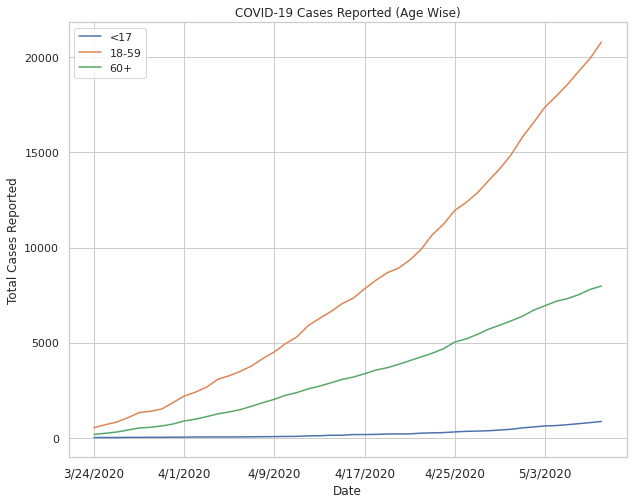

In [0]:
plt.figure(figsize=(10,8))
plt.plot(df_master['DATE'],df_master['Cases_CF_AGE_0_17'], label='<17')
plt.plot(df_master['DATE'],df_master['Cases_CF_AGE_18_59'], label='18-59')
plt.plot(df_master['DATE'],df_master['Cases_CF_AGE_60plus'], label='60+')
plt.legend(loc='best')
plt.title('COVID-19 Cases Reported (Age Wise)')
plt.ylabel('Total Cases Reported')
plt.xlabel('Date')
plt.xticks(np.arange(0, len(df), 8))
plt.xticks(fontsize = 12)
plt.show()

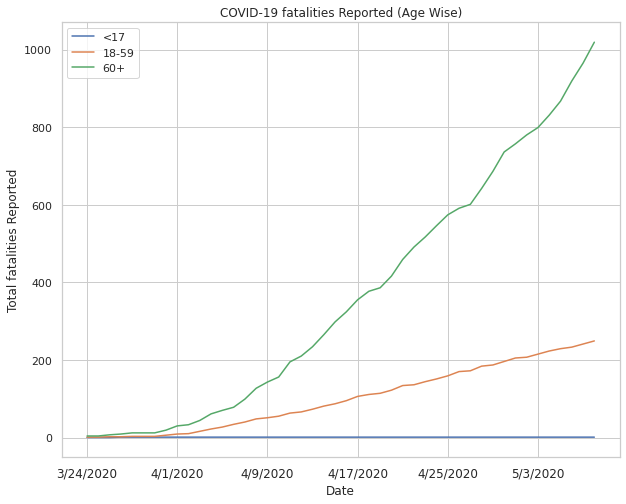

In [0]:
plt.figure(figsize=(10,8))
plt.plot(df_master['DATE'],df_master['Deaths_CF_AGE_0_17'], label='<17')
plt.plot(df_master['DATE'],df_master['Deaths_CF_AGE_18_59'], label='18-59')
plt.plot(df_master['DATE'],df_master['Deaths_CF_AGE_60plus'], label='60+')
plt.legend(loc='best')
plt.title('COVID-19 fatalities Reported (Age Wise)')
plt.ylabel('Total fatalities Reported')
plt.xlabel('Date')
plt.xticks(np.arange(0, len(df), 8))
plt.xticks(fontsize = 12)
plt.show()

Observation:
We see that more cases have been reported in age group 18-59 but when you see the total deaths reported, it's been mostly 60+.

Older Age(60+) have contaced the disease less than the younger population, but an average lesser immunity of the elderly may be a possible reason why there is a difference in number of fatalities than the younger population. 

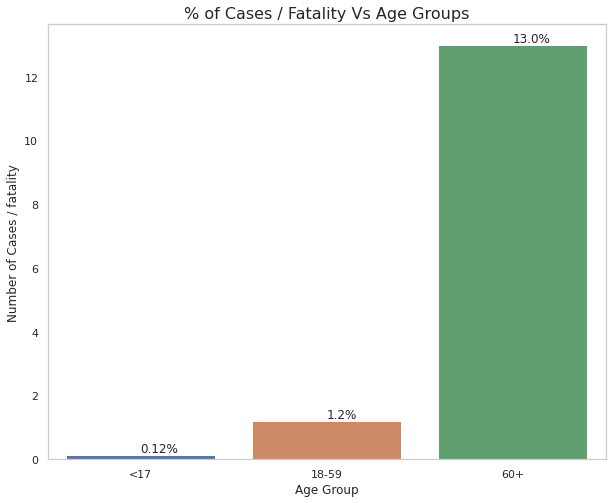

In [0]:
deaths_per_case_0_17     = round((df_master['Deaths_CF_AGE_0_17'][len(df)-1] / df_master['Cases_CF_AGE_0_17'][len(df)-1])*100,2)
deaths_per_case_18_59    = round((df_master['Deaths_CF_AGE_18_59'][len(df)-1] / df_master['Cases_CF_AGE_18_59'][len(df)-1])*100,2)
deaths_per_case_above_59 = round((df_master['Deaths_CF_AGE_60plus'][len(df)-1] / df_master['Cases_CF_AGE_60plus'][len(df)-1])*100.2)

x=['<17','18-59','60+']
y=[deaths_per_case_0_17, deaths_per_case_18_59, deaths_per_case_above_59]


sns.set(style="whitegrid")
plt.figure(figsize=(10,8))
plt.title("% of Cases / Fatality Vs Age Groups", fontsize=16)
ax = sns.barplot(x, y)
ax.set(xlabel='Age Group', ylabel='Number of Cases / fatality')
ax.text(0,deaths_per_case_0_17+.1,str(deaths_per_case_0_17)+'%')
ax.text(1,deaths_per_case_18_59+.1,str(deaths_per_case_18_59)+'%')
ax.text(2,deaths_per_case_above_59+.1,str(deaths_per_case_above_59)+'%')
ax.grid(False)
plt.show()

In [0]:
l1 = df_master['Deaths_CF_AGE_18_59'].tolist()
l2 = df_master['Deaths_CF_AGE_60plus'].tolist()

0.9999999999999994
1.543478260869565


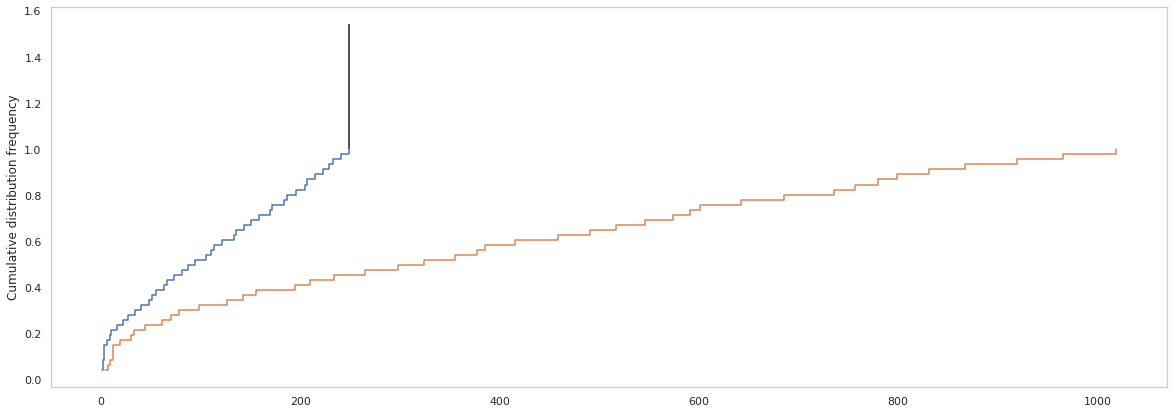

K-S statistic is 0.5434782608695654 point of max difference is 249
0.5434782608695654


In [0]:
res = ks_test(l1,l2)
print(res)

0.9999999999999994
1.9782608695652169


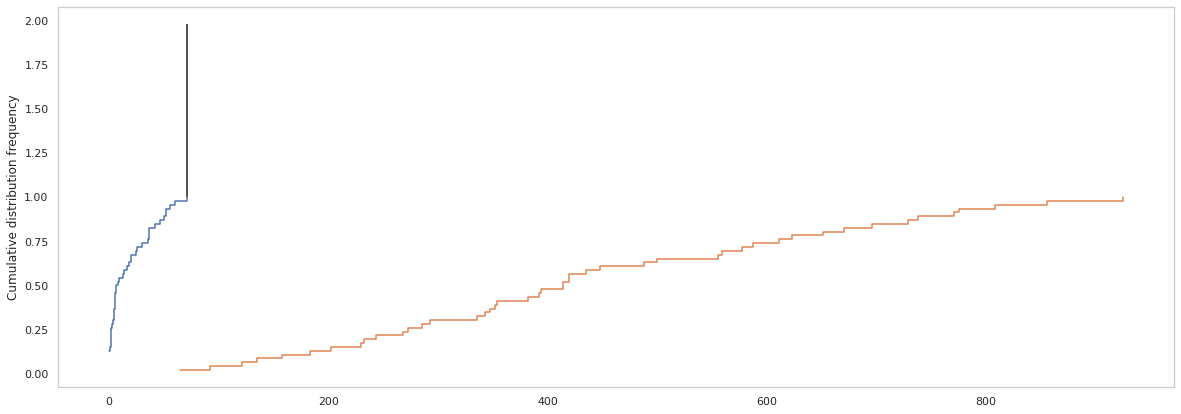

K-S statistic is 0.9782608695652174 point of max difference is 71
0.9782608695652174


In [0]:
l1 = df_master['Cases_AGE_0_17'].tolist()
l2 = df_master['Cases_AGE_18_59'].tolist()
res = ks_test(l1,l2)
print(res)

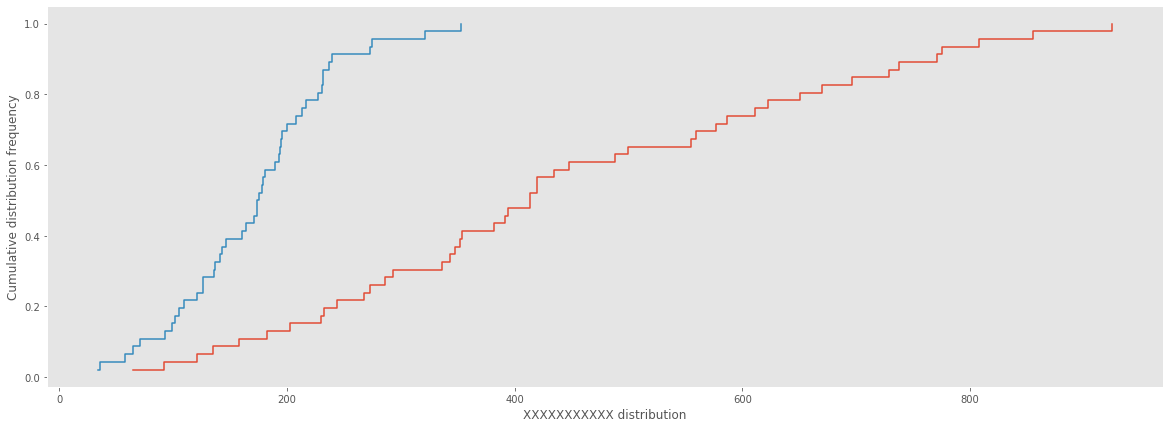

0.7173913043478256


In [0]:
l1 = df_master['Cases_AGE_18_59'].tolist()
l2 = df_master['Cases_AGE_60plus'].tolist()
res = ks_test(l1,l2)
print(res)

# New Inference 2 - lockdown before and after


In [0]:
before_lockdown = df_master.head(7)
after_lockdown = df_master.tail(7)
before_lockdown_mean = before_lockdown['Rate_of_cases'].mean()
after_lockdown_mean = after_lockdown['Rate_of_cases'].mean()
T_2_u_lockdown_num =   before_lockdown_mean -after_lockdown_mean

#T_2_U denominator is sqrt of sum of the variance 
variance_after_lockdown = variance(after_lockdown[['Rate_of_cases']].values)
variance_before_lockdown = variance(before_lockdown[['Rate_of_cases']].values)
T_2_u_lockdown_den = np.sqrt(variance_after_lockdown/len(before_lockdown) + variance_before_lockdown/len(before_lockdown))

#T test unpaired result 
T_unpaired_result_lockdown = (T_2_u_lockdown_num/T_2_u_lockdown_den)

if(T_unpaired_result_lockdown<-1.94):
  print("T two sample unpaired  testing rate of change of  cases mean  is T="+str(T_unpaired_result_lockdown) +" which is greater than t(6,alpha/2) = 1.94 so reject the NULL hypothesis")
else:
  print("T two sample unpaired  testing rate of change of  cases mean  is  T="+str(T_unpaired_result_lockdown)+ " which is less than t(6,alpha/2) = 1.94 so accept the NULL hypothesis")

T two sample unpaired  testing rate of change of  cases mean  is  T=[4.75463206] which is less than t(6,alpha/2) = 1.94 so accept the NULL hypothesis


#  Result of T 2 sample unpaired testing for mean of  rate of change of cases before and after lockdown

## Null hypothesis (H0):  
mean of rate of change of cases before lockdown  > mean of rate of change of cases after lockdown
## Alternate hypothesis(H1): 
mean of rate of change of cases before lockdown  < mean of rate of change of cases after lockdown

# Procedure :
Here we are trying to compare the the rate of change of cases beefore and after lockdown.

# Result: 
Here clearly the test shows that the rate of change of cases mean after lockdown is very much less than the rate of change of mean of cases before lockdown
As the T_two_sample_testing value for NULL Hypothesis is  = 4.73 which  is less than -2.18 we are accpeting the NULL hypothesis.



#Is this test Applicable ? 
Here we assume   that the  data X and Y 
to be independent and to be normally distributed.But here both the assumptions are fiiling so test is not applicable.